In [11]:
""" simple thermal evolution model, mantle and core """

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate, interpolate
import six
import math
from IPython.display import display, Math
import pandas as pd

In [12]:
###### PHYSICAL CONSTANTS #####~
M_E = 5.972e24 # earth mass in kg
R_E = 6371e3 # earth radius in m
L_sun =  3.9e26 # solar luminosity in W
#Q_cmb_Earth = 11e12 # heat flux from (Earth's) core in W
years2sec = 31557600
AU2m = 1.5e11
sb = 5.67e-8 # Stefan Boltzmann constant in W m^-2 K^-4
R_b = 8.3144598 # universal gas constant in J mol −1 K −1

# Half-lives in years from Dye (2012) in Treatise on Geophys
t_40K_half = 1.26e9 
t_235U_half = 7.04e8 
t_238U_half = 4.46e9
t_232Th_half = 1.4e10

# Heating rates of radioisotopes per mass of isotope in W kg^-1 from Dye (2012) in Treatise on Geophys
h_40K_0 = 28.47e-6
h_235U_0 = 568.47e-6
h_238U_0 = 95.13e-6
h_232Th_0 = 26.3e-6

# radioisotope abundances
# TODO: are the below values in moles or mass? 
K_0 = 0.0117e-2 # ratio of 40-K to total K at time 0 (in Treatise on Geophysics)
U_0_235 = 0.0072 # ratio of 235-U to total U at time 0 (in Treatise on Geophysics)
U_0_238 = 0.9927 # ratio of 238-U to total U at time 0 (in Treatise on Geophysics)
Th_0 = 1 # ratio of 232-Th to total Th at time 0 (in Treatise on Geophysics)
H_0 = [h_40K_0, h_235U_0, h_238U_0, h_232Th_0]
el_0 = [K_0, U_0_235, U_0_238, Th_0]
t_half = [t_40K_half, t_235U_half, t_238U_half, t_232Th_half]

In [13]:
####### INPUT PARAMETERS: default ######

fig_path = 'figs/'
L=1 # stellar luminosity in solar units
Alb=0 # planetary albedo
a = 1 # semimajor axis in au

Ra_crit = 660 # critical Rayleigh number (in Driscoll & Bercovici 2014)
rho_c = 8000 # Density of iron core in kg m^-3 
rho_m = 3300 #4500 # Density of silicate mantle in kg m^-3 
rho_lith = 2800
# what pressure should you take these densities at?
c_pm = 1200 # specific heat capacity from Dorn, Noack & Rozal 2018 in J kg−1 K−1 
#c_pm = 800 # specific heat capacity of silicate material (at constant volume) in J kg−1 K−1 (Elkins-Tanton+ 2011)
c_vc = 530 # speific heat capacity iron core Nimmo+ 1997
alpha_m = 4e-5 # Lees+2019 lithospheric mantle #2e-5 # thermal expansivity of silicate mantle in K^-1
k_m = 4 # thermal conductivity of silicate mantle in W m^−1 K^−1
k_lm = 10 # thermal conductivity lower mantle in W m^−1 K^−1 from Driscoll & Bercovici
#dT_core = 1000 # temperature jump across CMB in K
beta = 1/3 # Nusselt exponent
eta_m0 = 2.8e20 # Lees+ 2019

X_K = 250 # initial abundance of K in wt ppm (in Treatise on Geophysics, think these are by weight but double check)
X_U = 2e-2# initial abundane of U in wt ppm ""
X_Th = 7e-2 # initial abundance of Th in wt ppm ""
X_0 = [X_K, X_U, X_U, X_Th]

names={'T_m':'$T_m$ (K)', 'T_c':'$T_c$ (K)', 'D_l':'$D_l$ (km)', 'eta_m':'$\eta_m$ (Pa s)', 
       'eta_cmb':'$\eta_{cmb}$ (Pa s)', 'TBL_u':'$TBL_u$ (km)', 'TBL_c':'$TBL_c$ (km)', 
       'h_rad_m':'$h_{rad,m}$ (pW kg$^{-1}$)', 'H_rad_m':'$H_{rad,m}$ (TW)', 
       'q_ubl':'$q_{ubl}$ (mW m$^{-2}$)', 'M_mi':'$M_{mantle}$ (kg)','Q_ubl':'$Q_{ubl}$ (TW)',
       'Q_core':'$Q_{core}$ (TW)', 'q_sfc':'$q_{sfc}$ (mW m$^{-2}$)', 'Q_sfc':'$Q_{sfc}$ (TW)',
       'q_core':'$q_{core}$ (mW m$^{-2}$)', 'urey':'Urey ratio', 'Ra_i':'Ra$_i$'} # format variable_name:ylabel


In [14]:
###### ASTRONOMY ######

def luminosity(tau, L=None, **kwargs):
    return L
    
def q_star(t=None, Alb=None, a=None, **kwargs):
    """Calculate incident stellar flux density (over entire heliocentric sphere with radius a) in W m^-2"""
    return luminosity(t, **kwargs)*(1-Alb)/(4*np.pi*a**2) # 4pi is the total solid angle subtended by a sphere

def q_sfc_outgoing(R_p=None, SA_p=None, **kwargs):
    return q_star(**kwargs)*(np.pi*R_p**2)/SA_p # assume no geothermal contribution, pi*R^2 cancels out

def T_sfc(q_out=None, **kwargs):
    """Calculate equilibrium surface temperature given outgoing radiation in W m^-2"""
    return (q_out/sb)**(1/4)

In [15]:
###### GEOMETRY ######

def SA(M=None, rho=None, R=None, V=None):
    if R is None:
        if (V is None) and (M is not None) and (rho is not None):
            V = vol(M, rho)
        else:
            print('Missing mass or density to calculate volume')
        R = radius(V)
    return 4*np.pi*R**2

def radius_by_vol(V):
    return (3*V/(4*np.pi))**(1/3)

def radius_seager(M_p, CMF=0.3, k1=-0.20945, k2=0.0804, k3=0.394, m1=None, r1=None):
    if (m1 is None) and (r1 is None):
        if CMF==0.3:
            m1 = 6.41*M_E
            r1 = 2.84*R_E
        elif CMF==0.675:
            m1 = 6.41*M_E
            r1 = 3.19*R_E
        elif CMF==0: # all perovskite
            m1 = 7.38*M_E
            r1 = 3.58*R_E
    M_s = M_p/m1
    R_s = 10**(k1 + 1/3*np.log10(M_s) - k2*M_s**k3)
    return R_s*r1

def radius_otegi(M_p):
    return np.exp(1/3.45*np.log(M_p/0.9))

def radius_zeng(M_p, CMF=None):
    # applicable to M_E <= 8 and CMF <= 0.4
    print('using Zeng radius model')
    return (1.07 - 0.21*CMF)*(M_p/M_E)**(1/3.7)

def vol(M, rho):
    try:
        return M/rho
    except TypeError:
        return np.array(M)/np.array(rho)
    
def grav(M, R):
    """Calculate acceleration due to gravity on a point mass in m s^-2"""
    return 6.674e-11*M/R**2

In [16]:
###### SOME THERMODYNAMICS ######
def thermal_diffusivity(k, rho, C_p):
    """
    Calculate thermal diffusivity
    
    Parameters
    ----------
    k : Thermal conductivity
    C_p : Specific heat capacity in J K^-1 kg^-1
    rho : density in kg m^-3
    """
    return k/(rho*C_p)

def nu_Driscoll(T, nu_0=7e7, Ea=3e5, **kwargs):
    """kinematic viscosity (upper mantle) from eqn 6 in Driscoll & Bercovici"""
    return nu_0*np.exp(Ea/(R_b*T))/10

def nu_Dorn(T, nu_0=1.6e20, Ea=300e3, T_0=1800, **kwargs):
    # viscosity (below lithosphere) from Dorn, Noack & Rozal 2018
    return nu_0*np.exp(Ea/R_b*(T**-1-T_0**-1))

def nu_KW(T, p=0, **kwargs): # Karato & Wu 1993, diffusion law for dry olivine
    return 2.6e10*np.exp((3e5 + (6e3*p))/(R_b*T))   

def eta_Thi(T, eta_0=1e21, T_ref=1600, Ea=300e3, **kwargs): # diffusion creep, dry rheology (Thiriet+ 2019)
    return eta_0*np.exp(Ea/R_b*(T**-1 - T_ref**-1))

def adiabat(T_0, R=None, g=None, R_p=None, h=None, c_v=None, alpha_m=None, adiabatic=True, **kwargs):
    if adiabatic:
        R_0 = R_p - 0.5*h # depth to avg mantle temp (taken to be midpoint between surface and cmb)
        u = np.exp(-(R - R_0)*alpha_m*g/c_v) # page 39 driscoll & bercovici 2014
        #print('adiabatic T decrease', u)
        return u*T_0
    else:
        return T_0

def Ra(nu=None, eta=None, kappa=None, alpha=None, rho=None, g=None, deltaT=None, l=None):
    if (nu is None) and (eta is not None):
        return rho*alpha*deltaT*l**3*g/(kappa*eta)
    elif (nu is not None) and (eta is None):
        return alpha*deltaT*l**3*g/(kappa*nu)
    
def d_lid_ss(Tm, a_rh=None, k=None, Ea=None, H0=None, Ra_crit=None, eta_0=None, T_ref=None, 
          kappa_m=None, alpha_m=None, g_sfc=None, rho_m=None, Ts=None, **kwargs):
    """ from sympy solution for d in steady state """
    return ((-R_b*Tm**2*a_rh*k + np.sqrt(k*(2.0*Ea**2*H0*Tm*(Ea*Ra_crit*eta_0*kappa_m*np.exp(Ea/(R_b*Tm) - Ea/(R_b*T_ref))/(R_b*Tm**2*a_rh*alpha_m*g_sfc*rho_m))**0.666666666666667 - 2.0*Ea**2*H0*Ts*(Ea*Ra_crit*eta_0*kappa_m*np.exp(Ea/(R_b*Tm) - Ea/(R_b*T_ref))/(R_b*Tm**2*a_rh*alpha_m*g_sfc*rho_m))**0.666666666666667 - 2.0*Ea*H0*R_b*Tm**2*a_rh*(Ea*Ra_crit*eta_0*kappa_m*np.exp(Ea/(R_b*Tm) - Ea/(R_b*T_ref))/(R_b*Tm**2*a_rh*alpha_m*g_sfc*rho_m))**0.666666666666667 + R_b**2*Tm**4*a_rh**2*k)))/(Ea*H0*(Ea*Ra_crit*eta_0*kappa_m*np.exp(Ea/(R_b*Tm) - Ea/(R_b*T_ref))/(R_b*Tm**2*a_rh*alpha_m*g_sfc*rho_m))**(1/3)))
    
def sph_conduction(r, k_m=None, T_l=None, T_s=None, R_p=None, R_l=None,
                   a0=None, **kwargs):
    c1 = k_m*(T_l - T_s - a0/(6*k_m)*(R_p**2 - R_l**2))/(R_l**-1 - R_p**-1)
    c2 = T_s + a0/(6*k_m)*R_p**2 - c1/(k_m*R_p)
    return -a0/(6*k_m)*r**2 + c1/(k_m*r) + c2

def sph_flux(r, a0=None, k_m=None, T_l=None, T_s=None, R_p=None, R_l=None, **kwargs):
    c1 = k_m*(T_l - T_s - a0/(6*k_m)*(R_p**2 - R_l**2))/(R_l**-1 - R_p**-1)
    #c1 = ((T_l - T_s) + a0/(6*k_m)*(R_l**2 - R_p**2)) / ((k_m*R_p)**-1 - (k_m*R_l)**-1)
    dTdr = -a0/(3*k_m)*r - c1/(k_m*r**2)
    return -k_m*dTdr # for r>0 in m

def rect_flux(r, a0=None, q0=None, r0=None, **kwargs):
    c0 = q0 - a0*r0
    return a0*r + c0

In [17]:
###### TOPOGRAPHY ######
def dyn_topo(F, rho_m=None, rho_w=1000, alpha_m=None, eta_m=None, kappa_m=None, g_sfc=None, 
             k_m=None, C=5.4, **kwargs):
    return C*rho_m/(rho_m-rho_w) * ((alpha_m*F*eta_m*kappa_m)/(rho_m*g_sfc*k_m))**(1/2) # eqn 33 Parsons & Daly

In [37]:
###### THERMAL MODEL for stagnant lid adapted from Thiriet+ 2019 ######
def init(k_m=None, rho_m=None, rho_c=None, c_m=None, CMF=None, M_p=None, R_p0=None, R_c0=None, 
         T_s=None, **kwargs):
    if R_p0 is None:
        R_p = radius_zeng(M_p, CMF)*R_E # in m
    else:
        R_p = R_p0
    if R_c0 is None:
        M_m = M_p*(1 - CMF) # mass of mantle
        CRF = CMF**0.5 # Zeng & Jacobsen 2017
        M_c = M_p*CMF # M_p - M_m
        R_c = R_p*CRF
        #R_c = radius_seager(M_p*CMF, CMF=0, m1=4.34*M_E, r1=2.23*R_E) # EoS for iron... is this consistent?
    else:
        R_c = R_c0
        CRF = R_c0/R_p0
        M_c = 4/3*np.pi*R_c**3 * rho_c
        CMF = M_c/M_p
        M_m = 4/3*np.pi*(R_p**3 - R_c**3)*rho_m  #M_p - M_c
    SA_p = SA(R=R_p)
    SA_c = SA(R=R_c) # core surface area 
    h = R_p - R_c # mantle thickness
    g_sfc = grav(M_p, R_p)
    if CMF>0:
        g_cmb = grav(M_c, R_c)
    else:
        g_cmb = 0
    kappa_m = thermal_diffusivity(k_m, rho_m, c_m)
    
    if T_s is None:
        q_out = q_sfc_outgoing(**derargs, **kwargs)
        T_s = T_sfc(q_out)
    return dict(kappa_m=kappa_m, SA_p=SA_p, SA_c=SA_c, M_m=M_m, g_sfc=g_sfc, R_p=R_p, R_c=R_c,
                CRF=CRF, g_cmb=g_cmb, h=h, M_c=M_c, T_s=T_s)

def dyn_visc(T=None, nu_0=None, visc_type=None, rho_m=None, **kwargs):
    if visc_type=='constant':
        return nu_0*rho_m
    elif visc_type=='Dorn':
        return nu_Dorn(T, **kwargs)*rho_m
    elif visc_type=='KW':
        return nu_KW(T, **kwargs)*rho_m
    elif visc_type=='Driscoll':
        return nu_Driscoll(T, **kwargs)*rho_m
    elif visc_type=='Thi':
        return eta_Thi(T, **kwargs)

def bdy_thickness_beta(dT=None, R_l=None, R_c=None, Ra_crit=None, beta=None, g=None,
                       kappa_m=None, eta_m=None, Ea=None, alpha_m=None, rho_m=None, a_rh=None,**kwargs):
    """Thickness of thermal boundary layer """
    if beta is None:
        beta = 1/3
    Ra_rh = alpha_m*rho_m*g*dT*(R_l - R_c)**3 / (kappa_m*eta_m)
    return (R_l - R_c) * (Ra_crit/Ra_rh)**beta
    
def bdy_thickness(dT=None, Ra_crit=None, g=None, kappa_m=None, eta_m=None, alpha_m=None, rho_m=None, 
                  **kwargs):
    """Thickness of thermal boundary layer """
    return (Ra_crit*kappa_m*eta_m/(alpha_m*rho_m*g*dT))**(1/3)

def inv_bdy_thickness(dT=None, Ra_crit=None, g=None, kappa_m=None, eta_m=None, alpha_m=None, rho_m=None, 
                  **kwargs):
    """Thickness of thermal boundary layer """
#     print(alpha_m*rho_m*g*dT)
#     print((Ra_crit*kappa_m*eta_m))
#     print('a;pha', alpha_m, 'rho_m', rho_m, 'g', g, 'dT', dT, 'Ra_crit', Ra_crit, 'kappa', kappa_m, 'eta', eta_m)
    return ((alpha_m*rho_m*g*np.absolute(dT))/(Ra_crit*kappa_m*eta_m))**(1/3)
    
def h_rad_old(t=None, H_0=None, X_0=None, el_0=None, t_half=None, t_vect=False, **kwargs):
    """Calculate radiogenic heating in W kg^-1"""
    if not t_vect:
        return sum(H_0*X_0*el_0*np.exp(-np.log(2)*t/t_half))
    else:
        # for a list of ages
        h = np.zeros(len(t))
        for ii, val in enumerate(t):
            h[ii] = sum(H_0*X_0*el_0*np.exp(-np.log(2)*val/t_half))
        return h
    
def h_rad(t, tf=None, H_0=None, c_n=None, p_n=None, lambda_n=None, t_vect=False, **kwargs):
    """Calculate radiogenic heating in W kg^-1 from Korenaga (2006)"""
    x_n = np.array(c_n)*np.array(p_n)
    x_tot = sum(x_n)
    h_n = x_n/x_tot
    
    try:
        h = H_0*sum(h_n*np.exp(lambda_n*(tf-t)))
    except ValueError:
        # for a list of ages
        h = np.zeros(len(t))
        for ii, t_val in enumerate(t):
            h[ii] = H_0*sum(h_n*np.exp(lambda_n*(tf-t_val)))
    return h
        
def H_rad(t=None, M=None, **kwargs):
    """Calculate energy flux radioisotope decay in W"""
    h = h_rad(t, **kwargs)
    return h*M # mass cancels out

def q_bl(deltaT, k=None, d_bl=None, beta=None, d_bl_inv=None, **kwargs):
    if d_bl_inv is None:
        
        return k*deltaT/d_bl #a_BL*Ra_rh**beta_BL * k*deltaT/h
    else:
        return k*deltaT*d_bl_inv

def Q_bl(q=None, deltaT=None, SA=None, h=None, d_bl=None,
         adiabatic=False, beta=None, Ra_rh=None, **kwargs):
    """Calculate energy flux from conduction across thermal bdy layer in W""" 
    if q is None:
        return SA*q_bl(deltaT, k=k, d_bl=d_bl, beta=beta, **kwargs)
    else:
        return SA*q

def T_lid(T_m, a_rh=None, Ea=None, **kwargs):
    return T_m - a_rh*(R_b*T_m**2/Ea) # temperature at base of stagnant lid, Thiriet+ eq. 15

def lid_growth(T_m=None, q_ubl=None, h0=None, R_p=None, R_l=None, T_l=None, rho_m=None, T_s=None,
               c_m=None, k_m=None, **kwargs):
    
    a0 = h0*rho_m # radiogenic heating in W/m^3
    c1 = k_m*(T_l - T_s - a0/(6*k_m)*(R_p**2 - R_l**2))/(R_l**-1 - R_p**-1)
#     return (-q_ubl + a0*R_l + k_m*(T_l - T_s - (a0/(2*k_m)*(R_p**2 - R_l**2)))/(R_p-R_l))/(rho_m*c_m*(T_m - T_l)) # 1D rectangular
    return (-q_ubl + a0/3*R_l + c1/R_l**2)/(rho_m*c_m*(T_m - T_l)) # spherical

def dTdt(Q, M, C, **kwargs):
    """ temperature change 
    
    Q : flux balance in W
    M : mass in kg
    C : specific heat in J kg^-1 K^-1
    """
    return Q/(M*C)

def LHS(t, y, M_c=None, c_m=None, c_c=None, SA_c=None, adiabats=0, complexity=3, **kwargs):
    T_m = y[0]
    T_c = y[1]
    D_l = y[2]
    
    [R_l, T_l, eta_m, eta_cmb, nu_m, nu_cmb, TBL_u, h_rad_m, q_ubl, Q_ubl, Ra_i, Ra_crit_c, TBL_c, 
     q_core, Q_core, M_mi, M_lid, H_rad_m, a0, 
     H_rad_lid, q_sfc, Q_sfc, D_l] = outputs(t, 
                                             T_m=T_m, T_c=T_c, D_l=D_l, M_c=M_c, c_m=c_m, SA_c=SA_c, 
                                             complexity=complexity, **kwargs)

    if SA_c>0:
        dTdt_c = dTdt(-Q_core, M_c, c_c)
    else:
        dTdt_c = 0
    dTdt_m =  dTdt(-Q_ubl + H_rad_m + Q_core, M_mi, c_m)
    dDdt = lid_growth(T_m=T_m, q_ubl=q_ubl, h0=h_rad_m, R_l=R_l, T_l=T_l, c_m=c_m, **kwargs)
    if complexity==3:
        return [dTdt_m, dTdt_c, dDdt]
    elif complexity==2:
        return [dTdt_m, dTdt_c, 0]
    elif complexity==1:
        return [dTdt_m, 0, 0]

def solve(t0=0, tf=None, T_m0=None, T_c0=None, D_l0=None, complexity=3, **kwargs):
    kwargs = {**kwargs, **init(**kwargs)} # get derived parameters
    f = integrate.solve_ivp(fun=lambda t, y: LHS(t, y, **dict(tf=tf, complexity=complexity, **kwargs)), 
                            t_span=(t0,tf), y0=[T_m0, T_c0, D_l0], max_step=100e6*years2sec,
                            method='RK45', dense_output=False)
    return f

def outputs(t=None, T_m=None, T_c=None, D_l=None, T_s=None, M_m=None, M_c=None, c_m=None, c_c=None, 
            SA_p=None, SA_c=None, g_sfc=None, g_cmb=None, R_p=None, R_c=None, k_m=None, k_lm=None, 
            Ra_crit_u=None, beta_u=None, beta_c=None, rho_lith=None, adiabats=0, complexity=3, **kwargs):
    
    h_rad_m = h_rad(t, **kwargs) # W kg^-1
    a0 = h_rad_m*rho_m # radiogenic heating in W m^-3
    if complexity<3: # lid adjusts instantaneously
        D_l = d_lid_ss(T_m, k=k_m, H0=a0, Ra_crit=Ra_crit_u, g_sfc=g_sfc, Ts=T_s, **kwargs)
    
    R_l = R_p - D_l
    T_l = T_lid(T_m, **kwargs)
    V_lid = 4/3*np.pi*(R_p**3 - R_l**3)
    M_lid = V_lid*rho_m # should use another density?
    M_mi = M_m - M_lid
    if (beta_u is None) or (beta_c is None):
        h = None
    else:
        pass
    eta_m = dyn_visc(T=T_m, **kwargs)
    eta_cmb = dyn_visc(T=(T_c+T_m)/2, **kwargs)
    nu_m = eta_m/rho_m
    nu_cmb = eta_cmb/rho_m
    TBL_u = bdy_thickness_beta(dT=T_c-T_l, eta_m=eta_m, g=g_sfc, Ra_crit=Ra_crit_u, 
                               R_l=R_l, R_c=R_c, beta=beta_u, **kwargs)
    #TBL_u = bdy_thickness(dT=T_c-T_l, eta_m=eta_m, g=g_sfc, Ra_crit=Ra_crit_u, **kwargs)
    q_ubl = q_bl(deltaT=T_m-T_l, k=k_m, d_bl=TBL_u, beta=beta_u, **kwargs)
    Q_ubl = Q_bl(q_ubl, SA=4*np.pi*R_l**2) 
    Ra_i = Ra(eta=eta_m, kappa=kwargs['kappa_m'], alpha=kwargs['alpha_m'], rho=rho_m, 
              g=g_sfc, deltaT=T_m-T_l, l=R_l-R_c)
    Ra_crit_c = 0.28*Ra_i**0.21  
    
    if SA_c>0:
        TBL_c_inv = inv_bdy_thickness(dT=T_c-T_m, eta_m=eta_cmb, g=g_cmb, Ra_crit=Ra_crit_c, **kwargs)  
        q_core = q_bl(deltaT=T_c-T_m, k=k_lm, d_bl_inv=TBL_c_inv, beta=beta_c, **kwargs)
        Q_core = Q_bl(q_core, SA=SA_c) #Q_bl(deltaT=T_c-T_m, k=k_lm, SA=SA_c, d_BL=TBL_c,a_BL=a_BL_c, beta_BL=beta_BL_c, Ra_rh=Ra_Rh_c, **kwargs) # core flux in W
        TBL_c = TBL_c_inv**-1
    else:
        TBL_c=None
        Q_core = 0

    H_rad_m = H_rad(t, M=M_mi, **kwargs) # mantle radiogenic heating in W
    H_rad_lid = H_rad(t, M=M_lid, **kwargs) # lid radiogenic heating in W
    
    #q_sfc = sfc_flux(q_bl=q_ubl, R_p=R_p, R_l=R_l, m=2, **kwargs)
    q_sfc = sph_flux(R_p, a0=a0, T_l=T_l, R_l=R_l, k_m=k_m, T_s=T_s, R_p=R_p, **kwargs) # surface heat flux in W m^-2
    Q_sfc = q_sfc*4*np.pi*R_p**2
   # print('q_ubl', q_ubl*1e3, 'q_sfc', q_sfc*1e3, 'mW m^-3')
    return R_l, T_l, eta_m, eta_cmb, nu_m, nu_cmb, TBL_u, h_rad_m, q_ubl, Q_ubl, Ra_i, Ra_crit_c, TBL_c, q_core, Q_core, M_mi, M_lid, H_rad_m, a0, H_rad_lid, q_sfc, Q_sfc, D_l 


In [39]:
###### PLOTTING ######

def plot_output(f, names, ncols=6, title=None, plots_save=False, verbose=True, 
                compare_dir=None, fig_path='figs/', labelsize=15, legsize=16, lw=1, ls='-', **kwargs):
    kwargs = {**kwargs, **init(**kwargs)} # get derived constants
    T_m = f.y[0]
    T_c = f.y[1]
    D_l = f.y[2]
    [R_l, T_l, eta_m, eta_cmb, nu_m, nu_cmb, TBL_u, h_rad_m, q_ubl, Q_ubl, Ra_i, Ra_crit_c, TBL_c, 
     q_core, Q_core, M_mi, M_lid, H_rad_m, a0, 
     H_rad_lid, q_sfc, Q_sfc, D_l] = outputs(t, 
                                             T_m=T_m, T_c=T_c, D_l=D_l, M_c=M_c, c_m=c_m, SA_c=SA_c, 
                                             complexity=complexity, **kwargs)
    urey = (H_rad_m + H_rad_lid)/Q_sfc
    
    # scale for plotting
    h_rad_m = h_rad_m*1e12
    H_rad_m = H_rad_m*1e-12
    H_rad_lid = H_rad_lid*1e-12
    TBL_u = TBL_u*1e-3
    q_ubl = q_ubl*1e3
    D_l = D_l*1e-3
    Q_ubl = Q_ubl*1e-12
    q_sfc = q_sfc*1e3
    Q_sfc = Q_sfc*1e-12
    TBL_c = TBL_c*1e-3
    q_core = q_core*1e3
    Q_core = Q_core*1e-12
    
    nrows = int(np.ceil(len(names)/ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*3))
    
    out_vars = list(names.keys())
    ylabels = list(names.values())
    
    for n, par in enumerate(out_vars):
        ax = axes.flatten()[n]
        try:
            plot_one(ax, f.t*1e-9/years2sec, eval(par), 
                     '', ylabels[n])
        except ValueError:
            print('could\'t plot', par)
        if compare_dir is not None: 
            try: # if data exists to benchmark this param
                df = pd.read_csv(compare_dir+'/'+par+'.csv', header=None, names=['time', 'value'],
                                index_col=False)
                plot_one(ax, df['time'], df['value'], 
                         '', ylabels[n], c='r', labelsize=labelsize, legsize=legsize, lw=lw, ls=ls)
                ax.legend(['this work', compare_dir], frameon=False)
            except IOError:
                #print('file', str(compare_dir+'/'+par+'.csv'), 'not found')
                pass
        ax.set_xlim(0, f.t[-1]*1e-9/years2sec)
    
    while n < ncols*nrows:
        fig.delaxes(axes.flatten()[n])
        n += 1
        
    plot_setxlabel(axes, 'Age (Gyr)', 'all')
    if title is None:
        title = '%.2f'%(kwargs['M_p']/M_E)+' M$_E$, CMF='+str(CMF)
    axes[0][0].set_title(title, fontsize=labelsize)
    plt.tight_layout()
    if plots_save:
        fig.savefig(fig_path+'evol_M'+'%.2f'%(M_p/M_E)+'_CMF'+str(CMF)+'.pdf', bbox_inches='tight') 
    if verbose:
        print('\n        n timesteps =', len(f.t))
        print('$t_f$ =', f.t[-1]/(1e9*years2sec), 'Gyr')
        print(r'$R_p$ =', '%.2f'%(kwargs['R_p']/R_E), 'R_E =', '%.2f'%(kwargs['R_p']*1e-3), 'km')
#         print(r'$R_c$ =', '%.2f'%(kwargs['CRF']*kwargs['R_p']*1e-3), 'km')
        print('M_c', '%.2e'%kwargs['M_c'], 'kg')   
        print(r'$M_{m+lid}$ =', '%.2e'%(kwargs['M_m']), 'kg')
        print(r'$g_{sfc}$ =', '%.2f'%kwargs['g_sfc'], 'm s^-2')
        print(r'$g_{cmb}$ =', '%.2f'%kwargs['g_cmb'], 'm s^-2')
        print(r'$\kappa_m$', '%.6f'%kwargs['kappa_m'], 'm^2 s^-1')
#         print(r'$SA_c$ =', '%.2f'%(kwargs['SA_c']/kwargs['SA_p']), 'x SA_p')
        print(r'CRF =', '%.2f'%kwargs['CRF'])
#         print(r'$T_s$ =', '%.2f'%kwargs['T_s'], 'K')
        print(r'$h_0$ =', '%.2f'%(h_rad(0, **kwargs)*1e12), 'pW kg^-1')
        print(r'$h_{4.5}$ =', '%.2f'%(h_rad(4.5*1e9*years2sec, **kwargs)*1e12), 'pW kg^-1')
#         print(r'$H_0$ =', '%.2f'%(H_rad_m[0] + H_rad_lid[0]), 'TW')
#         print(r'$H_{4.5}$ =', '%.2f'%(H_rad_m[-1] + H_rad_lid[-1]), 'TW')
#         print(r'viscosity method:', kwargs['visc_type'])
        print(r'Urey ratio @ $t_f$ =', '%.2f'%urey[-1])
        print('q_sfc(t=0)', '%.2f'%q_sfc[0], 'mW m^-3')
    return fig

def snaps(f, plot_snapshots=None, fig_path=None, plots_save=False, **kwargs):
    kwargs = {**kwargs, **init(**kwargs)} # get derived constants
    T_m = f.y[0]
    T_c = f.y[1]
    D_l = f.y[2]
    [R_l, T_l, eta_m, eta_cmb, nu_m, nu_cmb, TBL_u, h_rad_m, q_ubl, Q_ubl, Ra_i, Ra_crit_c, TBL_c, 
     q_core, Q_core, M_mi, M_lid, H_rad_m, a0, 
     H_rad_lid, q_sfc, Q_sfc, D_l] = outputs(t, 
                                             T_m=T_m, T_c=T_c, D_l=D_l, M_c=M_c, c_m=c_m, SA_c=SA_c, 
                                             complexity=complexity, **kwargs)
    try:
        n_col = len(plot_snapshots)
    except:
        n_col = 1
    fig2, axes2 = plt.subplots(1,n_col,figsize=(3*n_col,5))
    for iax, ii in enumerate(plot_snapshots):
        plot_structure(ax=axes2[iax], t=f.t[ii], T_m=T_m[ii], T_c=T_c[ii], R_l=R_l[ii], 
                       T_l=T_l[ii], h_rad_m=h_rad_m[ii],
                       d_lbl = TBL_c[ii], d_ubl = TBL_u[ii], q_ubl = q_ubl[ii],
                       legsize=10, **kwargs)
    plt.tight_layout()
    if plots_save:
        fig2.savefig(fig_path+'profiles.pdf', bbox_inches='tight') 

def plot_structure(ax=None, t=None, T_m=None, T_c=None, R_p=None, R_l=None, R_c=None, T_l=None, 
                   h_rad_m=None, d_lbl=None, d_ubl=None, q_ubl=None,
                   labelsize=16, legsize=14, **kwargs):
    """ plot temp structure (for a given time) """
    r_c = np.linspace(0, R_c*1e-3)
    r_lbl = np.linspace(R_c*1e-3, (R_c+d_lbl)*(1e-3))
    r_m = np.linspace((R_c+d_lbl)*1e-3, (R_l-d_ubl)*1e-3) # radius for mantle in km
    r_ubl = np.linspace((R_l-d_ubl)*1e-3, (R_l)*1e-3)
    r_l = np.linspace(R_l*1e-3, R_p*1e-3) # radius for lid
    T_cond = sph_conduction(r_l*1e3, a0=h_rad_m*kwargs['rho_m'], T_l=T_l, R_p=R_p, R_l=R_l, **kwargs)
    q = sph_flux(r_l*1e3, a0=h_rad_m*kwargs['rho_m'], T_l=T_l, R_p=R_p, R_l=R_l, **kwargs)
        
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(3,5))
    ax.axhline(y=R_l*1e-3, ls='--', lw=1, c='xkcd:bluish purple')
    ax.axhline(y=R_c*1e-3, ls='--', lw=1, c='xkcd:clay')

    ax.plot(T_cond, r_l, c='xkcd:bluish purple')
    ax.plot(T_l + q_ubl/kwargs['k_m']*(R_l - r_ubl*1e3), r_ubl, c='xkcd:greenish')
    ax.plot([T_m]*len(r_m), r_m, c='xkcd:greenish')
    ax.plot([T_m, T_c], [(R_c+d_lbl)*1e-3, R_c*1e-3], c='xkcd:greenish', marker = None)
    ax.plot([T_c]*len(r_c), r_c, c='xkcd:clay')
        
    ax.set_ylabel('Radius (km)', fontsize=labelsize)
    ax.set_xlabel('Temperature (K)', fontsize=labelsize)
    ax.set_ylim([0, R_p*1e-3])
#     #ax.fill_between(x=x, y0=[0]*len(x), y1=[R_cmb*1e-3]*len(x), color='xkcd:gold') # core
    ax.text(T_cond[-1], 0, 'Core', ha='left', va='bottom', fontsize=legsize, c='xkcd:clay')
#     #ax.fill_between(x=x, y0=[R_cmb*1e-3]*len(x), y1=[R_p*1e-3]*len(x), color='xkcd:tomato') # mantle
    ax.text(T_cond[-1], R_c*1e-3, 'Convecting region', ha='left', va='bottom', fontsize=legsize, c='xkcd:greenish')
    ax.text(T_cond[-1], R_l*1e-3, 'Lid', ha='left', va='bottom', fontsize=legsize, c='xkcd:bluish purple')
    
    ax2 = ax.twiny()
    ax2.set_xlabel('Flux, steady-state (mW m$^{-2}$)', color='xkcd:grey')  
    ax2.plot(q*1e3, r_l, color='xkcd:grey')
    ax2.plot(q_ubl*1e3, r_ubl[0], marker='o', color='xkcd:grey')
    ax2.annotate('$q_{ubl}$', (q_ubl*1e3, r_ubl[-1]), color='xkcd:grey', fontsize=12, ha="left", va="top")
    ax2.tick_params(axis='x', labelcolor='xkcd:grey')
    
    ax.set_title(('%.1f'%(t*1e-9/years2sec))+' Gyr', fontsize=labelsize)

    return ax

def interp_benchmark(f, ax3=None, compare_dir=None, fig_path=None, plots_save=False, **kwargs):
    """ sanity check on q_sfc """
    kwargs = {**kwargs, **init(**kwargs)} # get derived constants
    T_m = f.y[0]
    T_c = f.y[1]
    D_l = f.y[2]
    [R_l, T_l, eta_m, eta_cmb, nu_m, nu_cmb, TBL_u, h_rad_m, q_ubl, Q_ubl, Ra_i, Ra_crit_c, TBL_c, 
     q_core, Q_core, M_mi, M_lid, H_rad_m, a0, 
     H_rad_lid, q_sfc, Q_sfc, D_l] = outputs(t, 
                                             T_m=T_m, T_c=T_c, D_l=D_l, M_c=M_c, c_m=c_m, SA_c=SA_c, 
                                             complexity=complexity, **kwargs)
    try:
        if ax3 is None:
            fig3, ax3 = plt.subplots(1, 1, figsize=(5,5))
        df = pd.read_csv(compare_dir+'/D_l.csv', header=None, names=['time', 'value'],
                         index_col=False) # in Gyr, mW m^-3
        f_D_l_interp = interpolate.interp1d(np.array(df['time']), np.array(df['value'])*1e3, kind='linear', axis=-1)

        df = pd.read_csv(compare_dir+'/T_l.csv', header=None, names=['time', 'value'],
                         index_col=False) # in Gyr, mW m^-3
        f_T_l_interp = interpolate.interp1d(np.array(df['time']), np.array(df['value']), kind='linear', axis=-1)


        temp = f.t*1e-9/years2sec # in Gyr
        iii = np.where((temp>=np.array(df['time']).min()) & (temp<=np.array(df['time']).max()))
        times0 = temp[iii]
        D_l_interp = f_D_l_interp(times0) # in m
        T_l_interp = f_T_l_interp(times0) # in K
        a0_interp = rho_m*h_rad(times0/(1e-9/years2sec), **kwargs) # in W m^-3
        R_p = kwargs['R_p']
        R_l_interp = R_p - D_l_interp
        q_sfc_interp = sph_flux(R_p, a0=a0_interp, T_l=T_l_interp, R_l=R_l_interp, 
                                **kwargs) # surface heat flux in W m^-2

        ax3.plot(times0, q_sfc[iii]*1e3, c='xkcd:black', label='this work')
        ax3.plot(times0, q_sfc_interp*1e3, c='xkcd:blue', label='Thiriet interp')
        df = pd.read_csv(compare_dir+'/q_sfc.csv', header=None, names=['time', 'value'],
                         index_col=False) # in Gyr, mW m^-3
        ax3.plot(df['time'], df['value'], c='xkcd:red', label='Thiriet digitised')
        ax3.legend(frameon=False, fontsize=14)
        ax3.set_xlabel('Time (Gyr)', fontsize=16)
        ax3.set_ylabel('$q_{sfc}$ (mW m$^{-2}$)', fontsize=16)

    #     plt.tight_layout()

        fig0, ax0 = plt.subplots(1,1,  figsize=(4,4))
        ax0.plot(times0, q_sfc[iii]*1e3 - q_sfc_interp*1e3, c='xkcd:grey')
        ax0.set_xlabel('Time (Gyr)', fontsize=14)
        ax0.set_ylabel('$\Delta q_{sfc}$ (mW m$^{-2}$)', fontsize=14)
        ax0.set_title('Mean error: $\pm$'+'%.2f'%np.mean(np.absolute(q_sfc[iii]*1e3 - q_sfc_interp*1e3))+' mW m$^{-2}$', 
                      fontsize=14)
        plt.tight_layout()
        if plots_save:
            fig3.savefig(fig_path+'interp_test.pdf')
            fig0.savefig(fig_path+'q_error.pdf')
    except FileNotFoundError as e:
        print(e)
        
def plot_one(ax, x, y, xlabel, ylabel, labelsize=15, legsize=16, lw=1, ls='-', marker=None, 
             ms=5, c='k', text=None, xticks=True, ylim=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(3,3))
    ax.set_xlabel(xlabel, fontsize=labelsize)
    ax.set_ylabel(ylabel, fontsize=labelsize)
    if not xticks:
        ax.set_xticks([])
    if ylim is not None:
        ax.set_ylim(ylim)
    ax.plot(x, y, c=c, lw=lw, ls=ls, marker=marker, ms=ms)
    ax.set_xlim(x.min(), x.max())
    if text is not None:
        ax.text(0.05, 0.95, text, ha='left', va='top', transform=ax.transAxes, fontsize=legsize)
    return ax

def plot_setxlabel(axes, label, style, labelsize=15):
    ny, nx = np.shape(axes) # assume 2D
    for ii, ax in enumerate(axes):
        for jj, a in enumerate(ax):
            if (style=='all') or ((style=='bottom') and (jj==ny-1)):
                a.set_xlabel(label, fontsize=labelsize)
            if (style=='bottom') and (jj<ny-1):
                a.set_xticks([])

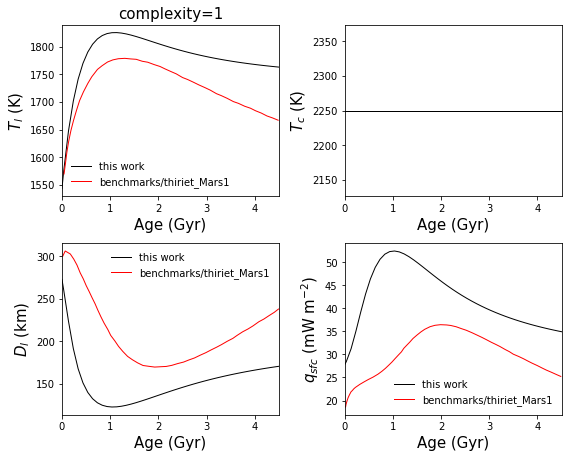

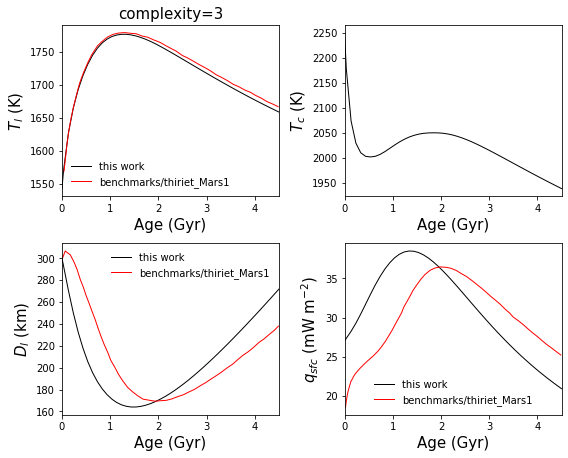

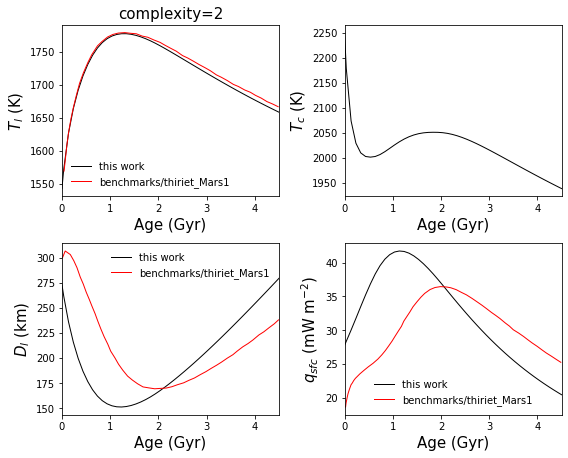

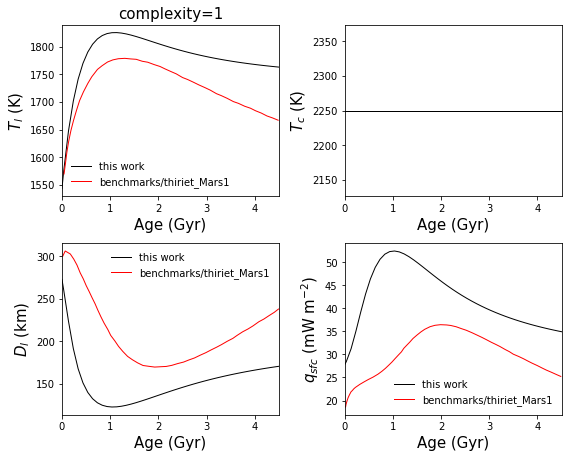

In [40]:
######  reproduce Thiriet+ 2019 Mars1
fig_path = '/space/cmg76/figs/' # office
R_p0 = 3400e3
R_c0 = 1700e3
Ra_crit = 450
T_m0 = 1750
T_c0 = 2250
D_l0 = 300e3 # initial lid thickness in m
rho_m = 3500
rho_c = 7200
c_m = 1142
c_c = 840
CMF = 0.24 # not used 
M_p = 6.39e23/M_E # in M_E; not used (except in gravity!)
beta_u = None # defaults to 1/3
beta_c = None # defaults to 1/3
a_rh = 2.44 #2.54 # they give results using 2.44 for beta=1/3
k_m = 4
k_lm = 4
alpha_m = 2.5e-5
T_s = 250
t_f = 4.5
# viscosity 
Ea = 300e3
eta_0 = 1e21
T_ref = 1600
X_K = 305 # initial abundance of K in wt ppm 
X_U = 16e-3 # initial abundane of U in wt ppm 
X_Th = 56e-3 # initial abundance of Th in wt ppm 
X_0 = [X_K, X_U, X_U, X_Th]
c_n = np.array([U_0_238, U_0_235, Th_0, K_0])*np.array([1, 1, X_Th/X_U, X_K/X_U]) # element abundance rel. to U
p_n = [9.37e-5, 5.69e-4, 2.69e-5, 2.79e-5] # heating per kg of isotope
lambda_n = np.array([0.155, 0.985, 0.0495, 0.555])*1e-9/years2sec # half life in sec
H_0 = 4e-12 # radiogenic heating in W/kg at t_f

# what to plot
names = {'T_l':'$T_l$ (K)', 'T_c':'$T_c$ (K)', 'D_l':'$D_l$ (km)', 'q_sfc':'$q_{sfc}$ (mW m$^{-2}$)',
         'q_core':'$q_{core}$ (mW m$^{-2}$)', 
         #'urey':'Urey ratio','q_ubl':'$q_{ubl}$ (mW m$^{-2}$)'
        }

kwargs = dict(Alb=Alb, rho_m=rho_m, H_0=H_0, c_n=c_n, p_n=p_n, lambda_n=lambda_n,
                 L=L*L_sun, Ra_crit_u=Ra_crit, adiabats=0, R_p0=R_p0, R_c0=R_c0,
                 alpha_m=alpha_m, k_m=k_m, CMF=None, rho_c=rho_c, rho_lith=rho_lith, visc_type='Thi',
                 c_m=c_m, #<----??? TODO: check if you need constant volume c_p
                 c_c=c_c, k_lm=k_lm, beta_u=beta_u, beta_c=beta_c, a_rh=a_rh, 
                 Ea=Ea, eta_0=eta_0, T_ref=T_ref, T_s=T_s, M_p=M_p*M_E, a=a*AU2m, 
                 T_m0=T_m0, T_c0=T_c0, D_l0 = D_l0, t0=0, tf=t_f*1e9*years2sec)

f_Mars1_3 = solve(**kwargs) # T_m, T_c, D_l
f_Mars1_2 = solve(complexity=2, **kwargs) # T_m, T_c
f_Mars1_1 = solve(complexity=1, **kwargs) # T_m

# snaps(f_Mars1_3, plot_snapshots=[0, 25, -1], fig_path=fig_path, plots_save=False, **kwargs)

plot_output(f_Mars1_3, names, title='complexity=3', ncols=2, plots_save=False, verbose=False,
            compare_dir='benchmarks/thiriet_Mars1', **kwargs)
plot_output(f_Mars1_2, names, title='complexity=2', complexity=2, ncols=2, plots_save=False, verbose=False,
            compare_dir='benchmarks/thiriet_Mars1', **kwargs)
plot_output(f_Mars1_1, names, title='complexity=1', complexity=1, ncols=2, plots_save=False, verbose=False,
            compare_dir='benchmarks/thiriet_Mars1', **kwargs)

# interp_benchmark(f_Mars1_3, compare_dir='benchmarks/thiriet_Mars1', fig_path=fig_path, plots_save=False, **kwargs)

# expect q_sfc to be off by 4.5 mW m^-3 average without PDE


        n timesteps = 66
$t_f$ = 4.5 Gyr
$R_p$ = 0.27 R_E = 1740.00 km
M_c 1.79e+21 kg
$M_{m+lid}$ = 7.20e+22 kg
$g_{sfc}$ = 1.62 m s^-2
$g_{cmb}$ = 0.79 m s^-2
$\kappa_m$ 0.000001 m^2 s^-1
CRF = 0.22
$h_0$ = 25.63 pW kg^-1
$h_{4.5}$ = 7.00 pW kg^-1
Urey ratio @ $t_f$ = 0.86
q_sfc(t=0) 25.86 mW m^-3
[Errno 2] File b'benchmarks/thiriet_Moon1/T_l.csv' does not exist: b'benchmarks/thiriet_Moon1/T_l.csv'


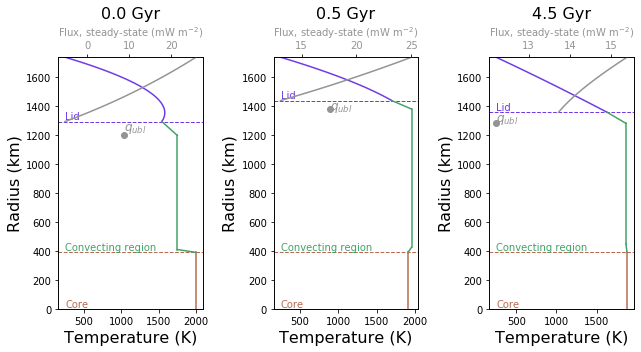

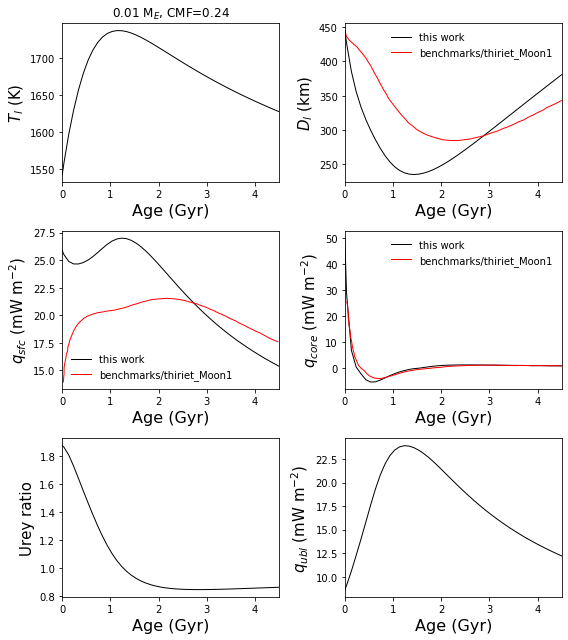

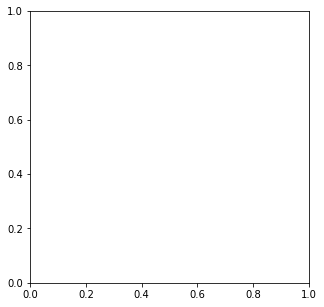

In [46]:
######  reproduce Thiriet+ 2019 Moon1
fig_path = '/space/cmg76/figs/' # office
M_p = 7.34767309e22/M_E
R_p0 = 1740e3
R_c0 = 390e3
Ra_crit = 450
T_m0 = 1750
T_c0 = 2000
D_l0 = 445e3 # initial lid thickness in m
rho_m = 3300
rho_c = 7200
c_m = 1142
c_c = 840
beta_u = 0.346 # defaults to 1/3
beta_c = None # defaults to 1/3
a_rh = 2.44 
k_m = 4
k_lm = 4
alpha_m = 2.5e-5
T_s = 250
t_f = 4.5
# viscosity 
Ea = 300e3
eta_0 = 1e21
T_ref = 1600
X_K = 83 # initial abundance of K in wt ppm 
X_U = 33e-3 # initial abundane of U in wt ppm 
X_Th = 125e-3 # initial abundance of Th in wt ppm 
X_0 = [X_K, X_U, X_U, X_Th]
c_n = np.array([U_0_238, U_0_235, Th_0, K_0])*np.array([1, 1, X_Th/X_U, X_K/X_U]) # element abundance rel. to U
p_n = [9.37e-5, 5.69e-4, 2.69e-5, 2.79e-5] # heating per kg of isotope
lambda_n = np.array([0.155, 0.985, 0.0495, 0.555])*1e-9/years2sec # half life in sec
H_0 = 7e-12 # radiogenic heating in W/kg at t_f

# what to plot
names={'T_m':'$T_m$ (K)', 'T_c':'$T_c$ (K)', 'D_l':'$D_l$ (km)', 'eta_m':'$\eta_m$ (Pa s)', 
       'eta_cmb':'$\eta_{cmb}$ (Pa s)', 'TBL_u':'$TBL_u$ (km)', 'TBL_c':'$TBL_c$ (km)', 
       'h_rad_m':'$h_{rad,m}$ (pW kg$^{-1}$)', 'H_rad_m':'$H_{rad,m}$ (TW)', 
       'q_ubl':'$q_{ubl}$ (mW m$^{-2}$)', 'M_mi':'$M_{mantle}$ (kg)','Q_ubl':'$Q_{ubl}$ (TW)',
       'Q_core':'$Q_{core}$ (TW)', 'q_sfc':'$q_{sfc}$ (mW m$^{-2}$)', 'Q_sfc':'$Q_{sfc}$ (TW)',
       'q_core':'$q_{core}$ (mW m$^{-2}$)', 'urey':'Urey ratio', 'Ra_i':'Ra$_i$'} # format variable_name:ylabel

names = {'T_l':'$T_l$ (K)', 'D_l':'$D_l$ (km)', 'q_sfc':'$q_{sfc}$ (mW m$^{-2}$)',
         'q_core':'$q_{core}$ (mW m$^{-2}$)', 'urey':'Urey ratio',
         'q_ubl':'$q_{ubl}$ (mW m$^{-2}$)'}

kwargs = dict(Alb=Alb, rho_m=rho_m, H_0=H_0, c_n=c_n, p_n=p_n, lambda_n=lambda_n,
                 L=L*L_sun, Ra_crit_u=Ra_crit, adiabats=0, R_p0=R_p0, R_c0=R_c0,
                 alpha_m=alpha_m, k_m=k_m, CMF=None, rho_c=rho_c, rho_lith=rho_lith, visc_type='Thi',
                 c_m=c_m, #<----??? TODO: check if you need constant volume c_p
                 c_c=c_c, k_lm=k_lm, beta_u=beta_u, beta_c=beta_c, a_rh=a_rh, 
                 Ea=Ea, eta_0=eta_0, T_ref=T_ref, T_s=T_s, M_p=M_p*M_E, a=a*AU2m, 
                 T_m0=T_m0, T_c0=T_c0, D_l0 = D_l0, t0=0, tf=t_f*1e9*years2sec)

f_Moon1 = solve(**kwargs)
snaps(f_Moon1, plot_snapshots=[0, 25, -1], fig_path=fig_path, plots_save=False, **kwargs)
plot_output(f_Moon1, names, ncols=2, plots_save=False, compare_dir='benchmarks/thiriet_Moon1', **kwargs)
interp_benchmark(f_Moon1, compare_dir='benchmarks/thiriet_Moon1', fig_path=fig_path, plots_save=False, **kwargs)

# expect q_sfc to be off by 4.5 mW m^-3 average


        n timesteps = 41
$t_f$ = 2.0 Gyr
$R_p$ = 0.38 R_E = 2440.00 km
M_c 2.45e+23 kg
$M_{m+lid}$ = 9.39e+22 kg
$g_{sfc}$ = 3.68 m s^-2
$g_{cmb}$ = 4.05 m s^-2
$\kappa_m$ 0.000001 m^2 s^-1
CRF = 0.82
$h_0$ = 9.14 pW kg^-1
$h_{4.5}$ = 3.07 pW kg^-1
Urey ratio @ $t_f$ = 0.45
q_sfc(t=0) 32.31 mW m^-3
[Errno 2] File b'benchmarks/thiriet_Mercury1/T_l.csv' does not exist: b'benchmarks/thiriet_Mercury1/T_l.csv'


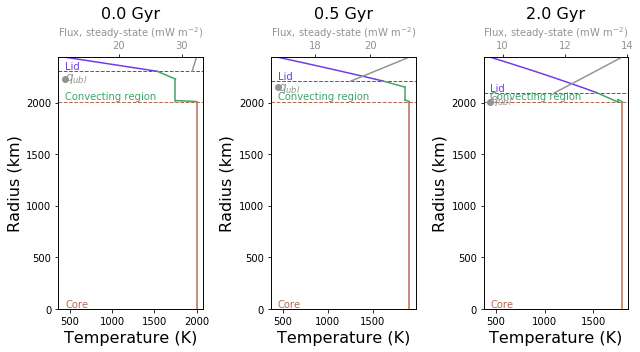

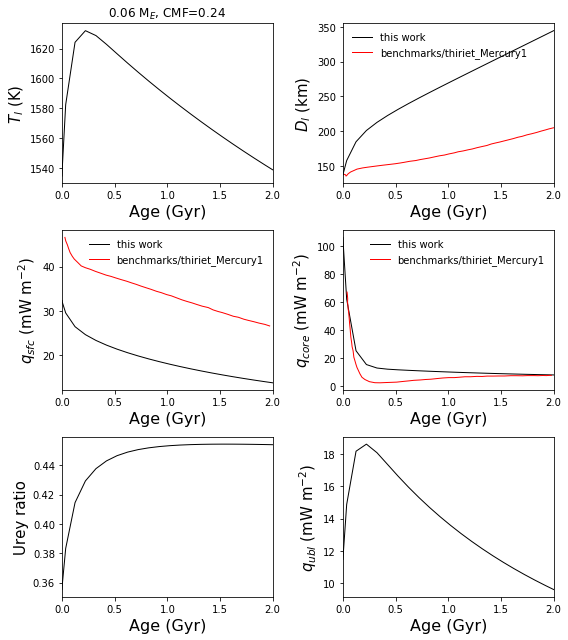

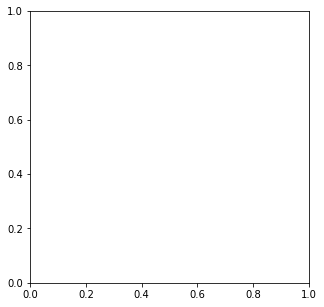

In [49]:
######  reproduce Thiriet+ 2019 Mercury1
fig_path = '/space/cmg76/figs/' # office
M_p = 3.285e23/M_E
R_p0 = 2440e3
R_c0 = 2010e3
Ra_crit = 450
T_m0 = 1750
T_c0 = 2000
D_l0 = 137e3 # initial lid thickness in m
rho_m = 3500
rho_c = 7200
c_m = 1142
c_c = 840
beta_u = 0.335 # defaults to 1/3
beta_c = None # defaults to 1/3
a_rh = 2.54 
k_m = 4
k_lm = 4
alpha_m = 2.5e-5
T_s = 440
t_f = 2
# viscosity 
Ea = 300e3
eta_0 = 1e21
T_ref = 1600
X_K = 400 # initial abundance of K in wt ppm 
X_U = 28e-3 # initial abundane of U in wt ppm 
X_Th = 50e-3 # initial abundance of Th in wt ppm 
X_0 = [X_K, X_U, X_U, X_Th]
c_n = np.array([U_0_238, U_0_235, Th_0, K_0])*np.array([1, 1, X_Th/X_U, X_K/X_U]) # element abundance rel. to U
p_n = [9.37e-5, 5.69e-4, 2.69e-5, 2.79e-5] # heating per kg of isotope
lambda_n = np.array([0.155, 0.985, 0.0495, 0.555])*1e-9/years2sec # half life in sec
H_0 = 5e-12 # radiogenic heating in W/kg at t_f

# what to plot
names={'T_m':'$T_m$ (K)', 'T_c':'$T_c$ (K)', 'D_l':'$D_l$ (km)', 'eta_m':'$\eta_m$ (Pa s)', 
       'eta_cmb':'$\eta_{cmb}$ (Pa s)', 'TBL_u':'$TBL_u$ (km)', 'TBL_c':'$TBL_c$ (km)', 
       'h_rad_m':'$h_{rad,m}$ (pW kg$^{-1}$)', 'H_rad_m':'$H_{rad,m}$ (TW)', 
       'q_ubl':'$q_{ubl}$ (mW m$^{-2}$)', 'M_mi':'$M_{mantle}$ (kg)','Q_ubl':'$Q_{ubl}$ (TW)',
       'Q_core':'$Q_{core}$ (TW)', 'q_sfc':'$q_{sfc}$ (mW m$^{-2}$)', 'Q_sfc':'$Q_{sfc}$ (TW)',
       'q_core':'$q_{core}$ (mW m$^{-2}$)', 'urey':'Urey ratio', 'Ra_i':'Ra$_i$'} # format variable_name:ylabel

names = {'T_l':'$T_l$ (K)', 'D_l':'$D_l$ (km)', 'q_sfc':'$q_{sfc}$ (mW m$^{-2}$)',
         'q_core':'$q_{core}$ (mW m$^{-2}$)', 'urey':'Urey ratio',
         'q_ubl':'$q_{ubl}$ (mW m$^{-2}$)'}

kwargs = dict(Alb=Alb, rho_m=rho_m, H_0=H_0, c_n=c_n, p_n=p_n, lambda_n=lambda_n,
                 L=L*L_sun, Ra_crit_u=Ra_crit, adiabats=0, R_p0=R_p0, R_c0=R_c0,
                 alpha_m=alpha_m, k_m=k_m, CMF=None, rho_c=rho_c, rho_lith=rho_lith, visc_type='Thi',
                 c_m=c_m, #<----??? TODO: check if you need constant volume c_p
                 c_c=c_c, k_lm=k_lm, beta_u=beta_u, beta_c=beta_c, a_rh=a_rh, 
                 Ea=Ea, eta_0=eta_0, T_ref=T_ref, T_s=T_s, M_p=M_p*M_E, a=a*AU2m, 
                 T_m0=T_m0, T_c0=T_c0, D_l0 = D_l0, t0=0, tf=t_f*1e9*years2sec)

f_Mercury1 = solve(**kwargs)
snaps(f_Mercury1, plot_snapshots=[0, 25, -1], fig_path=fig_path, plots_save=False, **kwargs)
plot_output(f_Mercury1, names, ncols=2, plots_save=False, compare_dir='benchmarks/thiriet_Mercury1', **kwargs)
interp_benchmark(f_Mercury1, compare_dir='benchmarks/thiriet_Mercury1', fig_path=fig_path, plots_save=False, **kwargs)

# expect q_sfc to be off by 4.5 mW m^-3 average

In [ ]:
###### reproduce Nimmo & McKenzie 1997 

T_m0 = 3000 # initial mantle temp in K
T_c0 = 3000 # initial core temp in K
M_p = 1 # M_E
CMF = 0.3
t_f = 4 # Gyr
nu_m=5.5e15
rho_m=4800
alpha_m = 4e-5
k_m = 3.11
k_lm = 3.11
beta = 0.25
T_s = 450+273
visc_type='constant'


In [ ]:
###### reproduce Kite+ 2009 stagnant lid model (melting?) 

alpha_m = 3e-5
k_m = 4.18
c_pm = 914
rho_m = 3400
CMF = 0.325
T_m0 = 3273

In [ ]:
###### reproduce Venus fig 6 in Driscoll & Bercovici FAILED 
alpha_m = 3e-5
c_pm = 1265
k_m = 4.2
k_lm = 10
rho_m = 4800
M_p = 1 #4.867e24/M_E # M_E
CMF = 0.3
t_f = 4 # Gyr
T_m0 = 2510 # initial mantle temp in K
T_s = 737


In [219]:
c_n = np.array([U_0_238, U_0_235, Th_0, K_0])*np.array([1, 1, 56/16, 305e3/16])
p_n = [9.37e-5, 5.69e-4, 2.69e-5, 2.79e-5]
lambda_n = np.array([0.155, 0.985, 0.0495, 0.555])*1e-9/years2sec
tf = 4.5e9*years2sec
h_0 = h_rad(0, tf, 4e-12, c_n, p_n, lambda_n)
h_f = h_rad(4.5e9*years2sec, tf, 4e-12, c_n, p_n, lambda_n)
print('H_t0 =', h_0, 'W/kg =', h_0*6.39e23*1e-11, 'TW')
print('H_tf =', h_f, 'W/kg =', h_f*6.39e23*1e-11, 'TW')

H_t0 = 2.217642585962431e-11 W/kg = 141.70736124299933 TW
H_tf = 4e-12 W/kg = 25.56 TW
